In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import re
import glob
from numpy import mean
from numpy import std
from scipy import stats
from keras.models import Sequential
from keras.callbacks import History 
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import ConvLSTM2D
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

# Load Dataset

Load Dataset, concatenate data and count Rows and Columns

In [ ]:
# Download dataset from Github and unzip
!wget 'https://github.com/cargilgar/Smart-Alarm-using-tinyML/raw/main/dataset/dataset-1-30.zip'

!unzip dataset-1-30.zip

In [41]:
#Create full dataframe with all subject csv's concatenated
path = r'content/output/'
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    subject_csv = pd.read_csv(filename, index_col=None, header=0)
    li.append(subject_csv)

df = pd.concat(li, axis=0, ignore_index=True)

#Save big dataframe as CSV
df.to_csv('big_df.csv')

#Rows and Columns
total_rows=len(df.axes[0]) #===> Axes of 0 is for a row
total_cols=len(df.axes[1]) #===> Axes of 1 is for a column
print("Number of Rows: "+str(total_rows))
print("Number of Columns: "+str(total_cols))

Number of Rows: 25614
Number of Columns: 6


In [42]:
# Read full dataframe CSV (without download data)
df = pd.read_csv('big_df.csv')
df

,Unnamed: 0,Time,X,Y,Z,Heart Rate,Labels
0,0,30.0,13.816742,16.912125,21.005707,63.142857,0.0
1,1,60.0,19.061356,19.994614,18.357467,61.000000,0.0
2,2,90.0,28.726898,23.026566,21.450897,79.428571,0.0
3,3,120.0,24.553680,20.227737,11.256195,79.166667,0.0
4,4,150.0,29.118179,24.300354,20.176254,83.000000,0.0
...,...,...,...,...,...,...,...
25609,25609,28934.0,25.938568,21.787765,17.890106,72.400000,0.0
25610,25610,28964.0,8.654251,26.127502,16.529953,76.166667,0.0
25611,25611,28994.0,8.590042,24.863663,15.814453,65.500000,0.0
25612,25612,29024.0,6.922333,26.481796,15.937668,64.000000,0.0


# Labels
Initial stages (0-5, wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 5)

Relabeled stages (0-2, wake = 0, NREM = 1, REM = 2)

In [43]:

# Show labels
# Same labels will be reused throughout the program

df['Labels'].describe()
#subject_csv.hist('Heart Rate')
#subject_csv.describe()

df['Labels'] = df['Labels'].map({0:0,1:1,2:1,3:1,5:2,},na_action=None)

#Delete non-labeled Rows
df.dropna(inplace=True)

# Normalize Training Data
Next, we need to normalize our features within our training data. Of course there are various ways on how to normalize. Please keep in mind that you use the same normalization algorithm later when feeding new data into your neural network. Otherwise your preditions will be off. On top of the normalization we will also apply rounding to the three features.

In [44]:
# Normalize features for training data set (values between 0 and 1)***
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df['X'] = df['X'] / df['X'].max()
df['Y'] = df['Y'] / df['Y'].max()
df['Z'] = df['Z'] / df['Z'].max()
df['Heart Rate'] = df['Heart Rate'] / df['Heart Rate'].max()

# Round numbers (4 decimals)
df = df.round({'X': 4, 'Y': 4, 'Z': 4, 'Heart Rate': 4})

# Split Dataset
Train, Validation and Test

Split the data
We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

***ANOTHER SPLITING OPTION WOULD BE TO SEPARATE USERS (Crear nueva columna con nombre usuario?? O manejar cada CSV por separado??)***





In [46]:
column_indices = {name: i for i, name in enumerate(df.columns)}

PERCENTAGE_TRAIN = 0.75
PERCENTAGE_VALIDATION = 0.15

n = len(df)
train_df = df[0:int(n*PERCENTAGE_TRAIN)]
val_df = df[int(n*PERCENTAGE_TRAIN):int(n*(PERCENTAGE_VALIDATION + PERCENTAGE_TRAIN))]
test_df = df[int(n*(PERCENTAGE_VALIDATION + PERCENTAGE_TRAIN)):]

num_features = df.shape[1]

# Reshape Data into Segments and Prepare for Keras
The data contained in the dataframe is not ready yet to be fed into a neural network. Therefore we need to reshape it. Let’s create another function for this called “create_segments_and_labels”. This function will take in the dataframe and the label names.

In [47]:
def create_segments_and_labels(dfs,labels):

    labels = dfs[labels]
    #segments = dfs[['Z','Heart Rate']]
    segments = dfs[['X','Y','Z','Heart Rate']] #All features

    return segments, labels

In [48]:
# x_train --> Features
# y_train --> Labels
   
x_train, y_train = create_segments_and_labels(train_df,'Labels')
x_val, y_val = create_segments_and_labels(val_df,'Labels')
x_test, y_test = create_segments_and_labels(test_df,'Labels')


# LSTM Model

In [49]:
#Prepare data for LSTM Model
x_train = np.expand_dims(x_train,-1) 
#y_train = np.expand_dims(y_train,-1) 
x_val = np.expand_dims(x_val,-1) 
#y_val = np.expand_dims(y_val,-1) 
x_test = np.expand_dims(x_test,-1) 
#y_test = np.expand_dims(y_test,-1) 

In [50]:
#Prepare labels data 
#Needed to categorical_crossentropy loss function
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, valX, valy):
    verbose, epochs, batch_size = 1, 100, 100

    n_timesteps = trainX.shape[1]
    n_features = trainX.shape[2]
    n_outputs = 3

    model = Sequential()
    model.add(LSTM(180, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.summary()
	# fit network
    history = model.fit(trainX, trainy, validation_data=(valX, valy), epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
    _, accuracy = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=verbose)
    return accuracy

In [ ]:
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [ ]:
def run_experiment(repeats=3):
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(x_train, y_train, x_val, y_val)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

In [ ]:
#Train model just 1 time
evaluate_model(x_train, y_train, x_val, y_val)

In [ ]:
#Run full training experiment
run_experiment()

>#1: 72.368
>#2: 72.610
>#3: 73.087
[72.36849069595337, 72.60979413986206, 73.08703064918518]
Accuracy: 72.688% (+/-0.299)


Confusion Matrix for LSTM

In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
y_pred_test = model.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

# Deep Neural Network Model in Keras


In [ ]:
# Reverse array dimension changes for LSTM
x_train = x_train[:, :, 0]
x_val = x_val[:, :, 0]
x_test = x_test[:, :, 0]

In [ ]:
#Prepare labels data 
#Needed ONLY for categorical_crossentropy loss function
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
# define the keras model
num_classes = 3

model = Sequential()
model.add(Dense(30, input_dim= x_train.shape[1], activation='relu'))
#model.add(Dense(60, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) #Last layer corresponds with the number of possible outputs

# compile the keras model
opt = SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 30)                150       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 93        
Total params: 243
Trainable params: 243
Non-trainable params: 0
_________________________________________________________________


Train Model

In [ ]:
# fit the keras model on the dataset
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=180, verbose=1)

# Evaluate Model on Test Data

In [ ]:
# evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

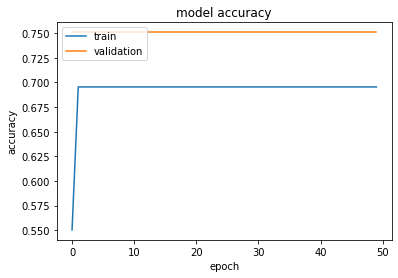

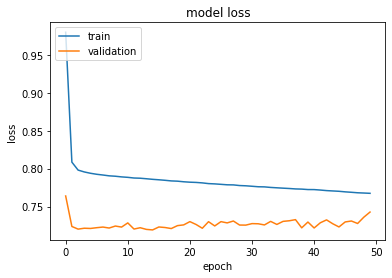

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predictions (Working on it)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
index = 1
predictions[index]

In [ ]:
np.argmax(predictions[index])

In [ ]:
print(y_test[:5])



---



---



---




---



---



---



---



---



---



---



---



---


---



---



---



---



---


---



---



---



---




Shuffle the training set because we will be using the validation_split option later when training.

In [ ]:
'''idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [ ]:
#create lstm model
n_timesteps = x_train.shape[1]
n_features = x_train.shape[2]
n_outputs = 3

model = Sequential()
model.add(LSTM(180, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(30, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# train model
verbose, epochs, batch_size = 1, 100, 100
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, verbose=verbose)

In [ ]:
# test the trained model with the full x_test
predictions = model.predict(x_test)

In [74]:
predictions[0], y_test[0]

(array([0.02846027, 0.89990205, 0.07163768], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [75]:
predictions[500], y_test[500]

(array([0.05969261, 0.7548642 , 0.18544324], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [76]:
predictions[800], y_test[800]

(array([0.06639516, 0.5557858 , 0.37781912], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [77]:
predictions[1200], y_test[1200]

(array([0.04926674, 0.74609387, 0.20463938], dtype=float32),
 array([0., 1., 0.], dtype=float32))

In [79]:
predictions[2000], y_test[2000] # bad prediction

(array([0.05706638, 0.7967321 , 0.14620142], dtype=float32),
 array([0., 0., 1.], dtype=float32))

In [85]:
predictions[2400], y_test[2400]

(array([0.05789682, 0.83688635, 0.10521688], dtype=float32),
 array([0., 1., 0.], dtype=float32))